In [7]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
import torch
from tqdm.notebook import tqdm
from torch import nn
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from torch.distributions.categorical import Categorical
import time
import datetime

from torch.optim import AdamW
import torch.nn.functional as F
import random

# import pandas_datareader.data as web
# import fix_yahoo_finance as yf

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/MitchLeahy/Stock-Trading-Bot-A2C-PPO/main/AAPL.csv")


df['Date'] = pd.to_datetime(df['Date'])

# sort date values
df = df.sort_values('Date',ascending=True)
try:
    df.drop(columns=['Unnamed: 0'], inplace=True)
except:
    pass

start_idx = 5535 
end_idx = 6039
test_start = 6040
test_end = 6270

window_size= 5
df.set_index('Date', inplace=True)

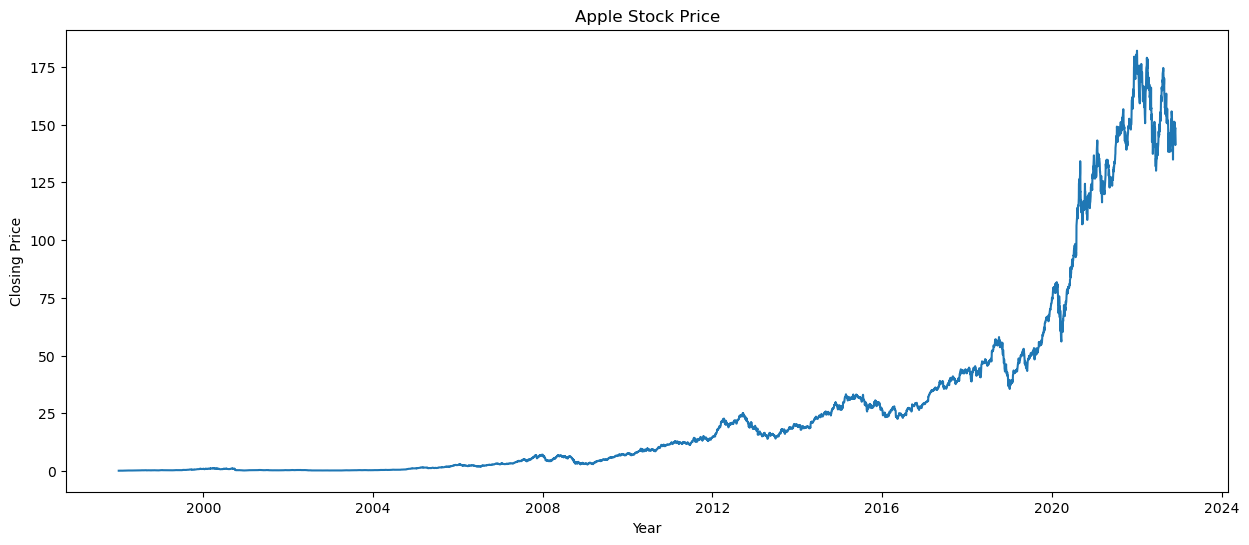

In [11]:
plt.figure(figsize=(15,6))
plt.cla()
plt.plot(df['Close'])
plt.title('Apple Stock Price')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.show()

# Account for stock splits

In [15]:
"""
Environment Details:

    df: pandas dataframe with the stock data
    frame_bound: tuple of (start, end) for index of the env data
    window_size: number of previous steps to use as state
"""


env = gym.make('stocks-v0', df=df, frame_bound=(start_idx,end_idx), window_size=window_size)


## Importing Finta (adds additon features)

In [17]:
# pip install finta
from finta import TA
from gym_anytrading.envs import StocksEnv



## Fix Volume data type

In [18]:
# df['Volume'] = df['Volume'].apply(lambda x: float(x.replace(',', '')))

# Calculate indicators using TA(finta)

In [19]:
df['SMAl'] = TA.SMA(df, 10, column = 'Low')
df['SMAh'] = TA.SMA(df, 10, column = 'High')
df['RSI'] = TA.RSI(df)
df['MACD'] = TA.MACD(df, period_fast = 5, period_slow = 15, column = 'Low').MACD
df.fillna(0, inplace=True)


In [20]:
df

,Open,High,Low,Close,Adj Close,Volume,SMAl,SMAh,RSI,MACD
Date,,,,,,,,,,
1998-01-02,0.121652,0.145089,0.120536,0.145089,0.123676,718110400,0.000000,0.000000,0.000000,0.000000
1998-01-05,0.147321,0.147879,0.135603,0.141741,0.120823,651873600,0.000000,0.000000,0.000000,0.001004
1998-01-06,0.142299,0.178571,0.131696,0.169085,0.144131,1812473600,0.000000,0.000000,89.791246,0.000825
1998-01-07,0.167969,0.169643,0.154576,0.156250,0.133190,1041622400,0.000000,0.000000,61.759228,0.003295
1998-01-08,0.155692,0.166295,0.151228,0.162388,0.138422,774020800,0.000000,0.000000,67.056012,0.003809
...,...,...,...,...,...,...,...,...,...,...
2022-11-25,148.309998,148.880005,147.119995,148.110001,148.110001,35195900,147.487996,150.942998,50.923058,1.784732
2022-11-28,145.139999,146.639999,143.380005,144.220001,144.220001,69246000,147.388997,150.605998,45.964363,0.673005
2022-11-29,144.289993,144.809998,140.350006,141.169998,141.169998,83763800,146.680998,150.058998,42.472211,-0.634794


# Apply new signals to enviornment


In [21]:
def add_signals(env):
    # get the start index of the env
    start = env.frame_bound[0] - env.window_size
    # get the end index of the env
    end = env.frame_bound[1]
    # get the target data from the env
    target = env.df.loc[:,'Low'].to_numpy()[start:end]
    # get the signal data from the env
    signal_features = env.df.loc[:,['Low','Volume','RSI', 'MACD', 'SMAl', 'SMAh']].to_numpy()[start:end]

    return target, signal_features

def calculate_reward(self, action):
        step_reward = 0

        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            if self._position == Positions.Long:
                step_reward += 1.5*(price_diff)
        if self._position == Positions.Long and self.prices[self._current_tick] - self.prices[self._current_tick - 1]> 0:
            step_reward += .66*(self.prices[self._current_tick] - self.prices[self._current_tick - 1])
        if self._position == Positions.Short and self.prices[self._current_tick] - self.prices[self._current_tick - 1] < 0:
            step_reward += -.66 *(self.prices[self._current_tick] - self.prices[self._current_tick - 1])
        return step_reward

In [53]:
class CustomEnv(StocksEnv):
    _process_data = add_signals
    _calculate_reward = calculate_reward
env_new= CustomEnv(df=df, frame_bound=(start_idx,end_idx), window_size=window_size, )

# Build the enviornment and train

In [54]:
env_new.reset().reshape(-1)
torch.from_numpy(np.array(env_new.reset().reshape(-1))).float()
ep_return = torch.zeros((1, 1))
ep_return

env= env_new

In [77]:


policy = nn.Sequential(
    nn.Linear(env.reset().reshape(-1).shape[0], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, env.action_space.n), 
    nn.Softmax()) #makes sure values are between 0 and 1 and sum to 1


value_net = nn.Sequential(
    nn.Linear(env.reset().reshape(-1).shape[0], 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)) # otuput is a single state value
    


def actor_critic(policy, value_net, env,episodes, alpha =1e-4,gamma=.99):
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim = AdamW(value_net.parameters(), lr=alpha)
    stat = {'Actor Loss': [], 'Critic Loss': [], 'Reward': []}
    
    for episode in tqdm(range(episodes)):
        #put array into tensor
        state = env.reset()

        done = False
        # tensor to store returns 
        ep_return = torch.zeros((1, 1))
        I = 1
        state = torch.from_numpy(np.array(state.reshape(-1))).float()
        while not done:
            # call policy with present state to generate action probabilities

            action = np.argmax(policy(state).detach())
            
            next_state, reward, done, _ = env.step(action)
            next_state = torch.from_numpy(next_state.reshape(-1)).float()
            reward = torch.tensor(reward).float()
            done = torch.tensor(done)
            
            #UPDATE Critic NET
            # update Critic network using SGD
            value = value_net(state)
            #generate target value
            target = reward + ~done *  gamma * value_net(next_state).detach()
            #compute loss
            critic_loss = F.mse_loss(value, target)

      
            #delte gradiennt stored in critic network
            value_optim.zero_grad()
            #backprop
            critic_loss.backward()
            #update weights using .step()
            value_optim.step()

            #UPDATE Actor NET
            #measure the difference bewteen the log probability of the action taken and the log probability of the action that would have been taken under the current policy 
            advantage = (target - value).detach()
            #calculate the probabilities
            probs = policy(state)
            #compute log probability of action taken
            log_prob = torch.log(policy(state)+1e-3) 
            log_prob = log_prob.gather(0, action)
            #calculate policy loss
            actor_loss = torch.abs((-I * log_prob * advantage )) #+ 1e-3
            #delte gradiennt stored in Actor network
            policy_optim.zero_grad()
            #backprop
            actor_loss.backward()
            #update weights using .step()
            policy_optim.step()

            ep_return += reward
            state = next_state
            #decrease gamma
            I *= gamma

            # store stats
        stat['Actor Loss'].append(abs(actor_loss.item()))
        stat['Critic Loss'].append(critic_loss.item())
        stat['Reward'].append(ep_return.item())
    return stat   

In [78]:
stats = actor_critic(policy, value_net, env,300, alpha =1e-5,gamma=.99)

  0%|          | 0/300 [00:00<?, ?it/s]

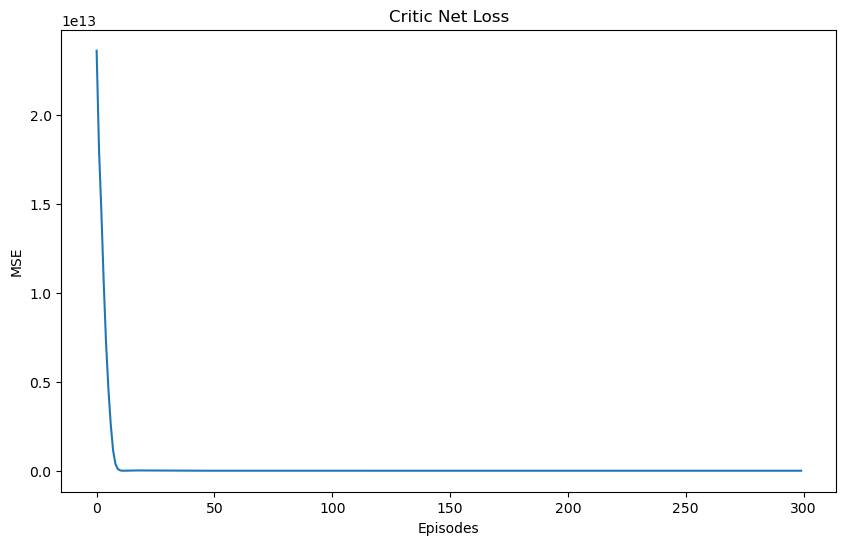

In [90]:
plt.figure(figsize=(10,6))
plt.cla()
plt.plot(stats['Critic Loss'])
plt.title('Critic Net Loss')
plt.xlabel('Episodes')
plt.ylabel('MSE')
plt.show()

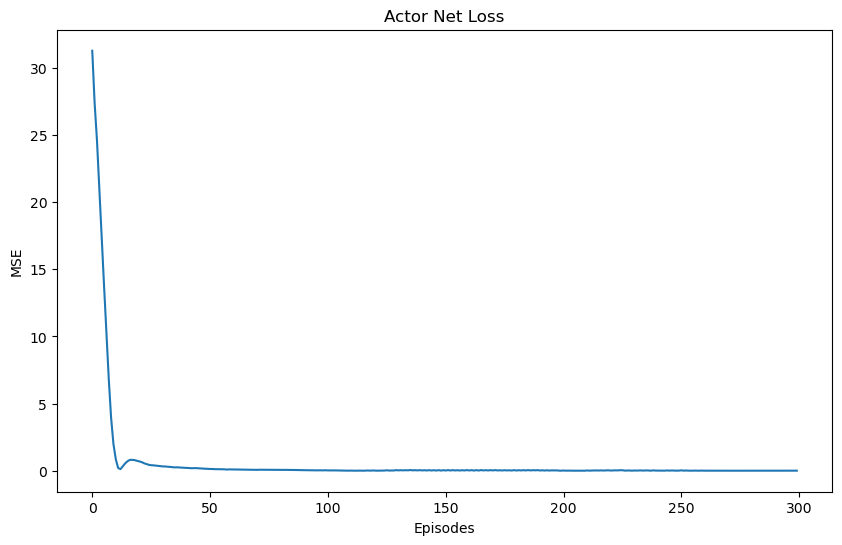

In [91]:
plt.figure(figsize=(10,6))
plt.cla()
plt.plot(stats['Actor Loss'])
plt.title('Actor Net Loss')
plt.xlabel('Episodes')
plt.ylabel('MSE')
plt.show()

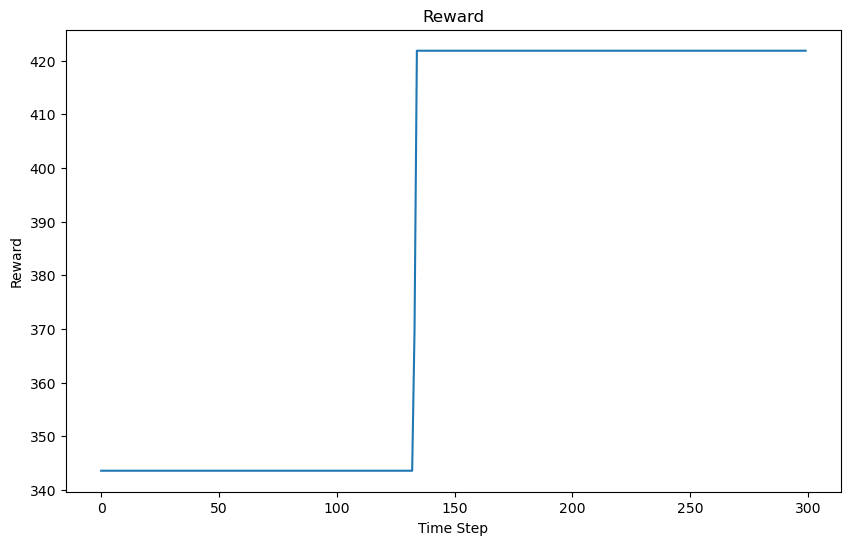

In [81]:
plt.figure(figsize=(10,6))

plt.plot(stats['Reward'])
plt.title('Reward')
plt.xlabel('Time Step')
plt.ylabel('Reward')
plt.show()

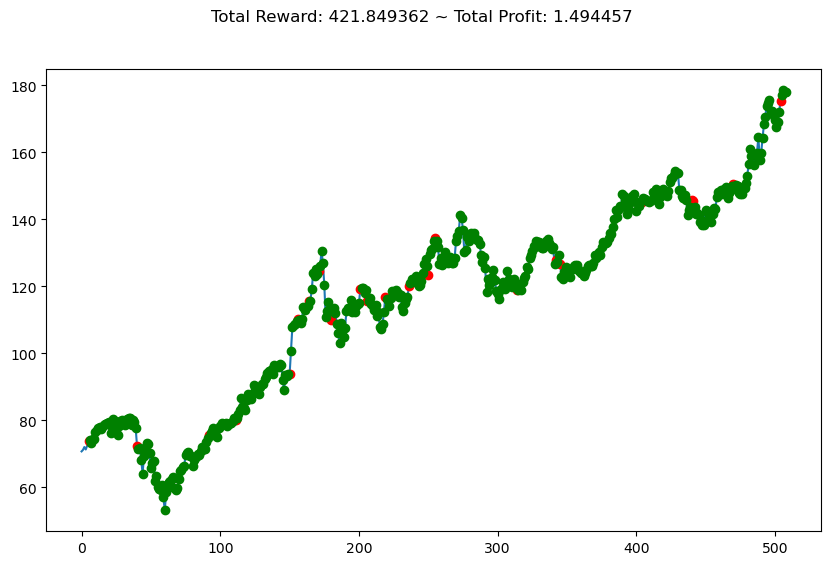

In [82]:
plt.figure(figsize=(10,6))
plt.cla()
env.render_all()
plt.show()

# Test A2C Home Grown

In [83]:
test_env = CustomEnv(df=df, frame_bound=(test_start,test_end), window_size=window_size, )


state = test_env.reset()
while True:
    state = torch.from_numpy(state.reshape(-1)).float()
    action = np.argmax(policy(state).detach())
    state,_,done,_ = test_env.step(action)
    if done:
            break


/Users/mitchleahy/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


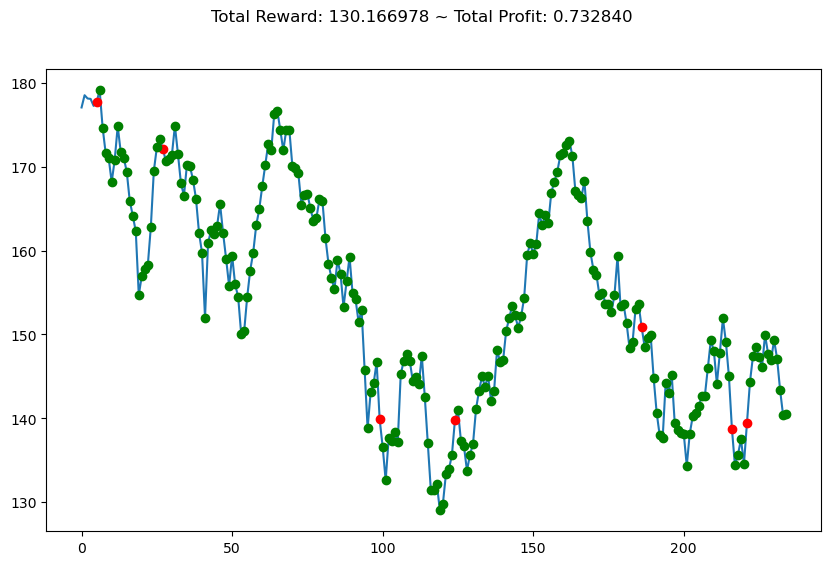

In [84]:
plt.figure(figsize=(10,6))
plt.cla()
test_env.render_all()

In [85]:
import copy
import altair as alt

In [86]:
test_df = copy.copy(test_env.df[test_start: test_end -1])
train_df = copy.copy(env.df[start_idx: start_idx + len(env.history['position'])])
test_df['position'] = test_env.history['position']
train_df['position'] = env.history['position']
test_df['date'] = test_df.index
train_df['date'] = train_df.index

In [87]:
(alt.Chart(test_df).mark_line().encode(
    x=alt.X('date'),
    y='Close'
) + alt.Chart(test_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('Close'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
)).properties(
    width = 1000,
    height = 500
)

alt.LayerChart(...)

In [88]:
(alt.Chart(train_df).mark_line().encode(
    x=alt.X('date'),
    y='Close'
) + alt.Chart(train_df).mark_circle().encode(
    x = alt.X('date'),
    y = alt.Y('Close'),
    color = alt.Color('position:N', scale=alt.
                    Scale(domain = [0,1], range=['red', 'green']))
)).properties(
    width = 1000,
    height = 500
)

alt.LayerChart(...)

In [92]:
# calculating the overall portfolio value over test data
pos = list(test_df['position'])
close = list(test_df['Close'])
record = []
first = True
cash = 0
for i in range(0,len(pos)):
    if pos[i] == 1:
        stock_val = close[i]
    if pos[i] == 1 and pos[i - 1] == 0:
        cash -= close[i]
    if pos[i] == 0 and pos[i - 1] == 1:
        cash += close[i]
        stock_val = 0
    record.append(cash+ stock_val)

test_df['portfolio_value'] = record

In [93]:
alt.Chart(test_df).mark_line().encode(
    x = 'date',
    y = 'portfolio_value'
).properties(
    width = 1000,
    height = 500
)

alt.Chart(...)